In [1]:
from pathlib import Path
import glob

import random
import math

import numpy as np
from numba import njit, prange

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def load_images(path: Path, thumbnail_shape: tuple) -> list[np.ndarray]:
    files = glob.glob(path.as_posix())
    images = []
    for f in files:
        img = Image.open(f).convert('L')
        img.thumbnail(thumbnail_shape, Image.Resampling.BICUBIC)
        img = np.array(img)
        img = -1+(img-img.min())/(img.max()-img.min())*(1-(-1))
        images.append(img)
    return images

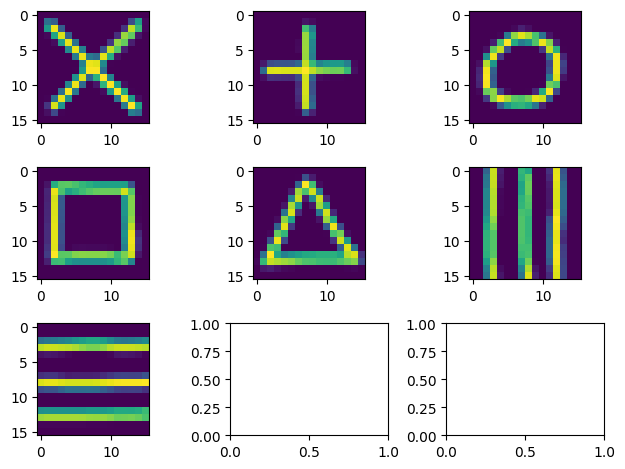

In [3]:
data = load_images(Path('..' , '..', 'data', 'images', 'shapes', '*'), (16, 16))

fig, axes = plt.subplots(nrows=3, ncols=3)

for i,ax in enumerate(axes.ravel()):
    if i < len(data):
        img = ax.imshow(data[i], cmap='viridis')
        
plt.tight_layout()
plt.show()

In [25]:
@njit(fastmath=True)
def fit(data: np.ndarray, n: int, lr: float) -> np.ndarray:
    w = np.zeros((n, n))
    idxs = np.random.permutation(data.shape[0])
    for i in idxs:
        u = np.exp(-np.abs(data[i]))*(data[i])
        w += lr*u*np.atleast_2d(u).T
    return w/n


@njit(fastmath=True)
def reconstruct(x: np.ndarray, w: np.ndarray, n: int, niter: int) -> np.ndarray:
    for i in prange(niter):
        idxs = np.random.permutation(n)
        for idx in idxs:
            x[idx] = max(-1, min(100*w[idx]@x, 1))
    return x


class HopfieldNetwork:
    def __init__(self, n: int) -> None:
        self.n: int = n
        self.memshape: tuple = (n, n)
        self.w: np.ndarray = np.zeros((n, n))

    def learn(self, data: list[np.ndarray], lr: float, niter: int):
        for i in range(niter):
            w = fit(np.array([d.flatten() for d in data]), self.n, lr)
            self.w = self.w + w
        self.w *= 1-np.eye(self.n)

    def reconstruct(self, x: np.ndarray, niter: int):
        return reconstruct(x.flatten(), self.w, self.n, niter)

In [26]:
m = 16
n = m*m
memshape = (n, n)

In [27]:
lr = 0.01

model = HopfieldNetwork(n)

for i in range(10):
    model.learn([data[5], data[6]], lr, 100)

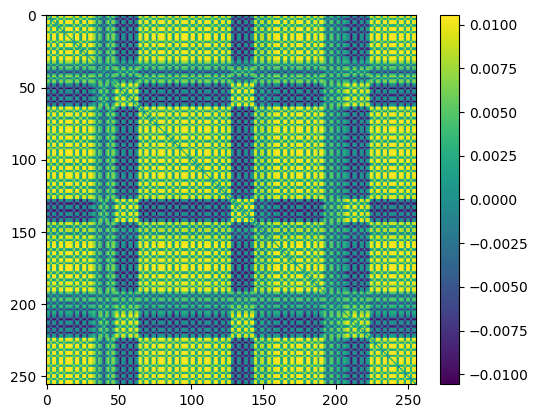

In [28]:
img = plt.imshow(model.w, cmap='viridis')
plt.colorbar(img)
plt.show()

Energy:  81.3976118169424


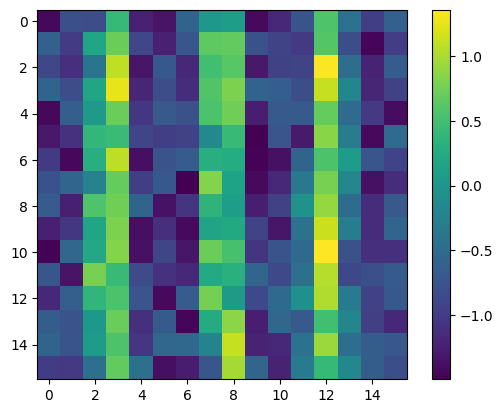

Energy:  93.24513924399551


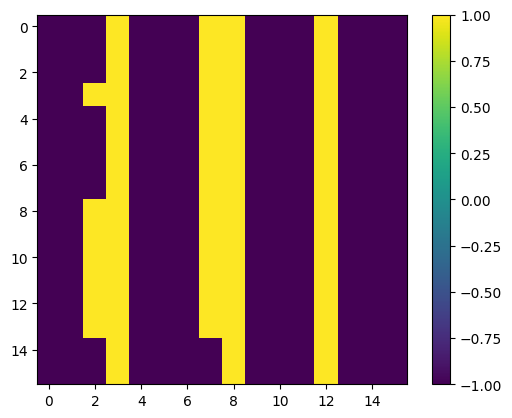

In [29]:
noise_amp = 0.5

x = data[5]+np.random.uniform(-noise_amp, noise_amp, (m, m))
y = model.reconstruct(x.flatten(), 100)

print('Energy: ', -1/2*np.sum(np.dot(model.w, x.ravel())))
img = plt.imshow(x, cmap='viridis')
plt.colorbar(img)
plt.show()

print('Energy: ', -1/2*np.sum(np.dot(model.w, y)))
img = plt.imshow(y.reshape((m, m)), cmap='viridis')
plt.colorbar(img)
plt.show()